# Setup

In [1]:
! pip install inferactively-pymdp
! pip install gymnasium

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym

from pymdp.agent import Agent
from pymdp import utils, maths

some plotitng functions

In [3]:
def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")

    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()

def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_point_on_grid(state_vector, grid_locations):
    """
    Plots the current location of the agent on the grid world
    """
    state_index = np.where(state_vector)[0][0]
    y, x = grid_locations[state_index]
    grid_heatmap = np.zeros((3,3))
    grid_heatmap[y,x] = 1.0
    sns.heatmap(grid_heatmap, cbar = False, fmt='.0f')

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

def plot_beliefs_2D(belief_dist, title_str=""):
    """
    Plot a 2-D belief distribution, stored in the 2-D numpy matrix `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")

    fig = plt.figure(figsize = (4,4))
    ax = sns.heatmap(belief_dist, cmap = 'RdYlGn', cbar = False, vmin = 0.0, vmax = 1.0, annot=True, linewidth=.5, fmt='.2f')
    plt.title(title_str)
    plt.show()


# Setup Environment

We've updated created an updated FrozenLake environment where the agent can still move after falling in holes. This environment also introduces the stay action, so that an agent can choose to stay in states it where it believes it will get preferred observations.

In [4]:
IS_SLIPPERY = True 

In [5]:
class FrozenLakeWrapper(gym.Wrapper):
  def __init__(self, env, is_slippery):
    super().__init__(env)
    # self.original_step = env.step
    # self.original_action_space = env.action_space
    self.is_slippery = is_slippery
    self.env_desc = np.array(env.unwrapped.desc, dtype='str')

    # add the stay action
    self.action_labels = ['left', 'down', 'right', 'up', 'stay']
    self.observation_labels = ['frozen', 'goal', 'hole']
    self.action_space = gym.spaces.Discrete(self.action_space.n + 1)

  def get_observation(self, state):
    if self.unwrapped.desc.flatten()[state] == b'H':
      return self.observation_labels.index('hole')
    elif self.unwrapped.desc.flatten()[state] == b'G':
      return self.observation_labels.index('goal')
    else:
      return self.observation_labels.index('frozen')

  def get_next_state(self, state, action):
    row, col = np.unravel_index(state, self.env_desc.shape)
    if action == 3 and row > 0:  # UP
        return state - self.env_desc.shape[1]
    elif action == 2 and col < self.env_desc.shape[1] - 1:  # RIGHT
        return state + 1
    elif action == 1 and row < self.env_desc.shape[0] - 1:  # DOWN
        return state + self.env_desc.shape[1]
    elif action == 0 and col > 0:  # LEFT
        return state - 1
    # if move in direction of wall don't move
    return state

  def step(self, action):
    '''
    Step now includes stay action, and is never "done"

    Returns:
      next location, temperature observation
    '''
    state = self.unwrapped.s
    obs = self.get_observation(state)
    # if stay do nothing
    if self.action_labels[action] == 'stay':
      return state, obs

    # Check if the agent is in a hole or the goal still move deterministicly
    if obs == self.observation_labels.index('hole') or obs == self.observation_labels.index('goal'):
        # change the direction of the sprite even though it won't acc move
        next_state, reward, done, truncated, info = self.env.step(action)
        # Manually update the state to reflect the action taken
        next_state = self.get_next_state(state, action)

        # Update the environment's internal state
        self.unwrapped.s = next_state
    else:
      # Take a step in the environment
      next_state, reward, done, truncated, info = self.env.step(action)

    return next_state, self.get_observation(next_state)

  # TODO: I found transition dynamics here: self.unwrapped.P. Can directly edit this to change and get the dynamics of movement
  def get_exact_transition_dynamics(self):
    '''
    This function returns the exact transition dynamics for the particular state
    Dynamics are represented using a probability matrix B[next state, curr state, action]
    '''
    num_states = self.observation_space.n
    num_actions = self.action_space.n
    B = np.zeros((num_states, num_states, num_actions))

    # directions we may slip in
    slip_directions = {
        0: [0, 1, 3], # going left  -> left, down, up
        1: [1, 0, 2], # going down  -> down, left, right
        2: [2, 1, 3], # going right -> right,down, up
        3: [3, 0, 2], # going up    -> up,   left, right
    }

    # iterate over all possible starting states
    for state in range(self.observation_space.n):
      x, y = np.unravel_index(state, self.env_desc.shape)
      # iterate over all actions we may take
      for action_index, action in enumerate(self.action_labels):
        # stay in same state w prob 1
        if action == 'stay':
          new_state = state
          B[new_state, state, action_index] = 1
        # if slipping is off or getting out of a hole/goal, always move in the intended direction
        elif not self.is_slippery or self.get_observation(state) != self.observation_labels.index('frozen'):
          new_state = self.get_next_state(state, action_index)
          B[new_state, state, action_index] = 1
        # slipping is on and we are on ice
        else:
          # consider each slip direction with equal probability
          for slip_action in slip_directions[action_index]:
            new_state = self.get_next_state(state, slip_action)
            B[new_state, state, action_index] += 1/3

    return B
  
  def get_naive_transition_dynamics(self):
    '''
    The naive transition dynamics make the assumption that a movement can lead to any one of the neighboring states with equal probability
    Dynamics are represented using a probability matrix B[next state, curr state, action]
    '''
    num_states = self.observation_space.n
    num_actions = self.action_space.n
    B = np.zeros((num_states, num_states, num_actions))

    # iterate over all possible starting states
    for state in range(self.observation_space.n):
      x, y = np.unravel_index(state, self.env_desc.shape)
      # iterate over all actions we may take
      for action_index, action in enumerate(self.action_labels):
        # lets get the adjacent states
        adjacent_states = []
        # cmpute the adjacent states (taking into account edges)
        for a in range(num_actions):
          adjacent_states.append(self.get_next_state(state, a))
        # remove duplicates
        adjacent_states = list(set(adjacent_states))
        # assign equal probability to each adjacent state
        for new_state in adjacent_states:
          B[new_state, state, action_index] = 1/len(adjacent_states)
    
    return B

In [6]:
# Start with a predetermined 4x4 map
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=IS_SLIPPERY, render_mode="rgb_array")
env = FrozenLakeWrapper(env, is_slippery=IS_SLIPPERY)

num_grid_points = env.observation_space.n
print(f'Number of grid points: {num_grid_points}')

# Get the map used in the environment
env_desc = env.env_desc
print(f'Environment description:\n {env_desc}')

# Get the start and goal states
start_loc = np.where(env_desc.flatten()=='S')[0].item()
goal_loc = np.where(env_desc.flatten()=='G')[0].item()
holes = np.where(env_desc.flatten()=='H')
print(f'Start state: {start_loc}')
print(f'Goal state: {goal_loc}')
print(f'Holes: {holes}')

Number of grid points: 16
Environment description:
 [['S' 'F' 'F' 'F']
 ['F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'H']
 ['H' 'F' 'F' 'G']]
Start state: 0
Goal state: 15
Holes: (array([ 5,  7, 11, 12]),)


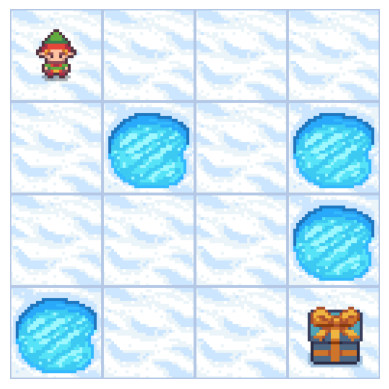

Transition Prob: 
[[0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Action: right
Observation: frozen


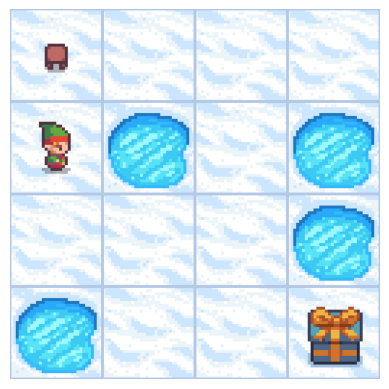

Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Action: down
Observation: frozen


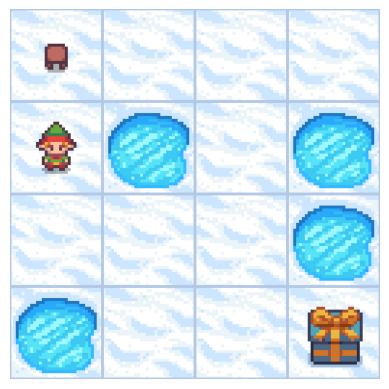

Transition Prob: 
[[0.33333333 0.         0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Action: right
Observation: frozen


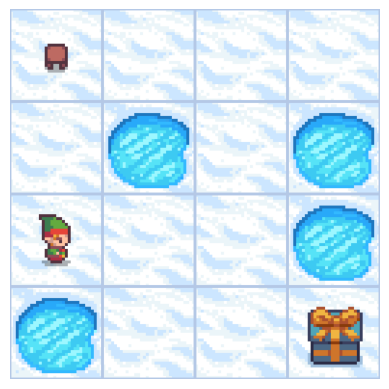

Transition Prob: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]]
Action: stay
Observation: frozen


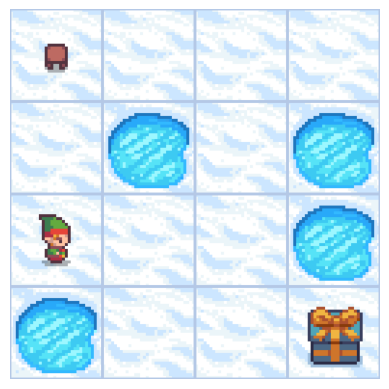

Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]]
Action: down
Observation: frozen


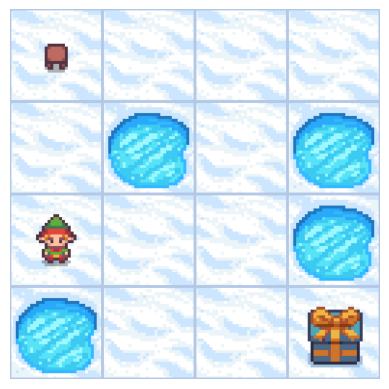

Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]]
Action: right
Observation: frozen


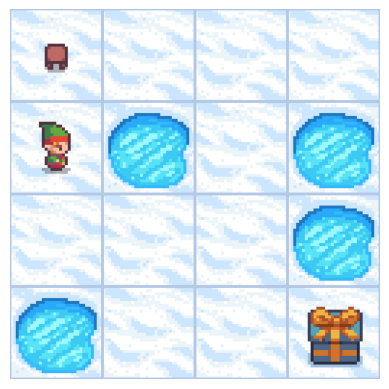

Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Action: down
Observation: frozen


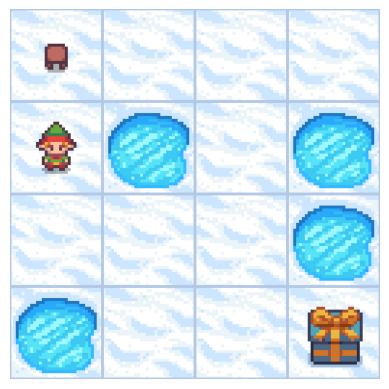

Transition Prob: 
[[0.33333333 0.         0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Action: left
Observation: frozen


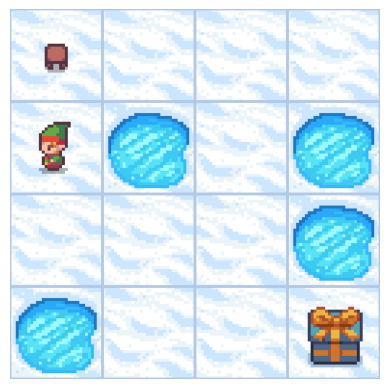

Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Action: down
Observation: frozen


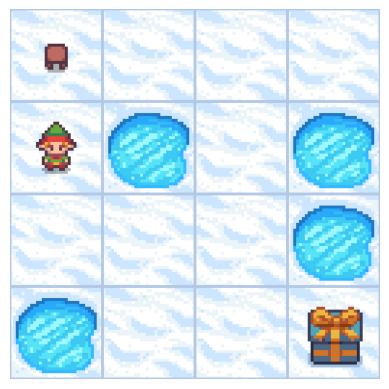

Transition Prob: 
[[0.33333333 0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Action: up
Observation: frozen


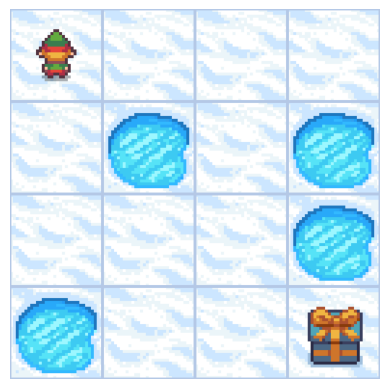

Transition Prob: 
[[0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Action: right
Observation: frozen


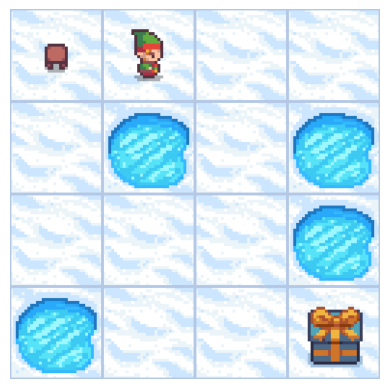

Transition Prob: 
[[0.33333333 0.         0.33333333 0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
Action: down
Observation: hole


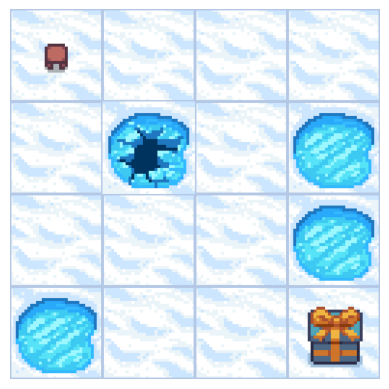

In [7]:
env.reset()

def render_img(env):
  img = env.render()
  plt.imshow(img)
  plt.axis('off')
  plt.show()

render_img(env)

# lets test some preset movements and render the images
test_action_labels = ['right', 'down', 'right','stay', 'down', 'right', 'down', 'left','down','up','right','down']
test_actions = [env.action_labels.index(action) for action in test_action_labels]

B = env.get_exact_transition_dynamics()
state = start_loc

for a in test_actions:
  print(f'Transition Prob: \n{B[:,state, a].reshape(4,4)}')
  state, obs = env.step(a)
  print(f'Action: {env.action_labels[a]}')
  print(f'Observation: {env.observation_labels[obs]}')
  render_img(env)

# Generative Model

## Defining state and observation factorizations

Only variable state is agents location.
For a static map, the reward observation actually isn't necessary because the location is exactly representative of what observations we want prefer. When the goal and the holes are randomized, then we need to know what we observe at each location bc its not a constant we have pre-modeled.

In [8]:
''' Define state factorization '''
# start with only dynamic variable being agents location
num_states = num_grid_points

''' Define observation factorization '''
# rewards are no reward (frozen tiles), goal (shelter), or hole (death)
reward_names = ['None', 'Goal', 'Hole']

num_obs = [num_grid_points, len(reward_names)]

print(f'Dimensionality of hidden states: {num_states}')
print(f'Dimensionality of observations: {num_obs}')

Dimensionality of hidden states: 16
Dimensionality of observations: [np.int64(16), 3]


## Defining observation likleihood:
Observation likelihood is rerpresented using matrix $A_{jk}=p(o=j|s_i=k)$ for each hidden factor $s_i$

In [9]:
# each modality A[m] is a conditional dist so [o_dim, states] where states are conditioned on
A_m_shapes = [ [o_dim] + [num_states] for o_dim in num_obs]
A = utils.obj_array_zeros(A_m_shapes)

''' Location factor '''
# start with proprioceptive (exact) observations about location
A[0] = np.eye(num_obs[0], num_states)

''' Reward factor'''
# receieve no reward at all states
A[1][0,:] = 1.0
# except receive reward when goal is reached
A[1][0, goal_loc] = 0.0
A[1][1, goal_loc] = 1.0
# and receive "hole" reward when falling in holes
for hole_loc in holes:
  A[1][0, hole_loc] = 0.0
  A[1][2, hole_loc] = 1.0

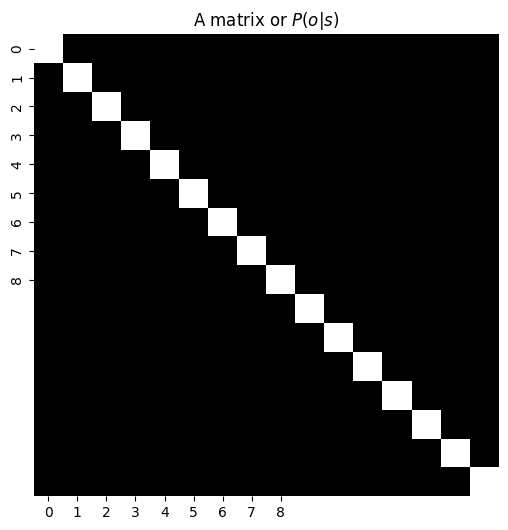

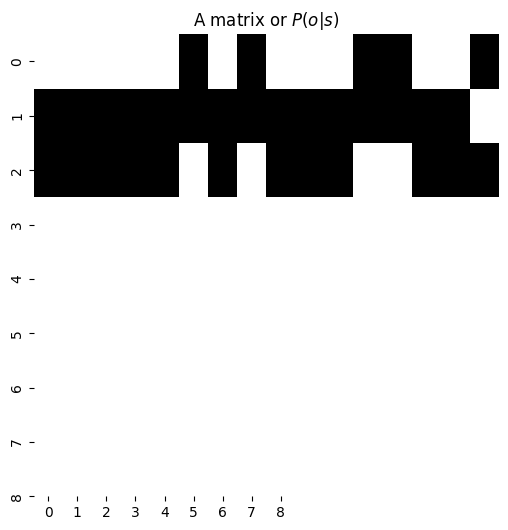

In [10]:
# TODO: make our own plotting functions
# observed state always matches the true location state
plot_likelihood(A[0], title_str = "A matrix or $P(o|s)$")
plot_likelihood(A[1], title_str = "A matrix or $P(o|s)$")

## Define transition dynamics $p(s_{t+1}|s_{t},\pi_{t})$
The transition matrix $B$ is dependent on the action being:
 $$B[i,j,k] = p(s_{t+1}=i|s_{t}=j,\pi_{t}=k)$$

We introduce an extra action "stay" in the grid world. This way our agent can choose to stay in the "shelter".

For now we only have a single factorization of the hidden state (location) so this is all we have to worry about

In [11]:
# import pymdp.envs

action_labels = ['left', 'down', 'right', 'up', 'stay']
num_actions = len(action_labels)

# if is slippery than there is 1/3 chance of moving in perpendicular direction
# B[next state, curr state, action]
B_true = env.get_exact_transition_dynamics()

# start with prior that our agent can only move to adjacent states, 
B = utils.obj_array_zeros([ [num_states, num_states, num_actions] ])
# i.e. actions lead to some adjacent state with equal probability
B[0] = env.get_exact_transition_dynamics()
# our dirichlet prior indicates how much to prefer this prior over the learned dynamics
# lets keep it small for now (make it smaller to learn even faster)
# pB = B * 1

## Define prior preferences (C) over observations
The only observation our agent should care about is the value of the reward observation factorization.
We can maybe rename this to the temperature observation?

In [12]:
C = utils.obj_array_zeros(num_obs)
# prefer shelter observation
C[1][reward_names.index('Goal')] = 4.0
# prefer not falling into holes
C[1][reward_names.index('Hole')] = -4.0

## Define the prior over hidden states $p(s_{t=1})$
Prior belief of agents location at the first time step. For now lets assume the agent knows it begins in the true hidden state top left corner.

In [13]:
D = utils.onehot(0, num_states)

# Active Inference

In [14]:
from scipy.special import kl_div

def kl_divergence_transition_matrix(B1, B2):
    """
    Compute the KL divergence between two transition matrices
    """
    if not np.isclose(B1.sum(axis=0), 1.0).all():
      raise ValueError(f"B1 not normalized")
    if not np.isclose(B2.sum(axis=0), 1.0).all():
      raise ValueError(f"B2 not normalized")

    # avoid divide by 0 issue (looks like kl_div does this)
    # B2 = B2 + 1e-10
    
    kl_divs = np.zeros((B1.shape[1], B1.shape[2]))
    # kl divergence is an expectation over probabliy dist so we need to sum over the next states 
    for state in range(B1.shape[1]):
      for action in range(B1.shape[2]):
        # TODO: see if the line below is correct
        # kl_div[state, action] = np.sum(B1[:,state,action] * (np.log(B1[:,state,action]) - np.log(B2[:,state,action])))
        kl_divs[state, action] = np.sum(kl_div(B1[:,state,action], B2[:,state,action]))
        
    return np.mean(kl_divs)

print("Starting KL divergence between true and prior for transition dynamics: ",kl_divergence_transition_matrix(B_true, B[0]))

# TODO: calculate KL divergence between dirichlet as well 
# def kl_divergence_dirichlet(pB1, pB2):

Starting KL divergence between true and prior for transition dynamics:  0.0


In [15]:
# define agent with our generative model
# policy_len=6 to compute the EFE over 6 timesteps in the future
# factors_to_learn='all' or 0 because we only have one factor rn
agent = Agent(A = A, B = B, C = C, D = D, policy_len=6, factors_to_learn='all') 

In [16]:
from tqdm import tqdm

def evaluate_trajectory(observation_history):
    '''
    Evaluate how often the agent observes reward vs holes
    '''
    num_holes, num_goals = 0, 0
    for obs in observation_history:
        if obs[1] == reward_names.index('Goal'):
            num_goals += 1
        elif obs[1] == reward_names.index('Hole'):
            num_holes += 1
    return num_holes, num_goals

def sample_action(agent, sample_method = 'efe'):
    if sample_method== 'efe':
        ''' calculate the EFE and sample action '''
        # calculate and infer a policy from EFE
        agent.infer_policies()
        # sample from marginalized EFE over next actions
        action = agent.sample_action()
        action = int(action[0])
    elif sample_method == 'random':
        ''' randomly sample an action '''
        action = np.random.choice(range(num_actions))
        # action_factors = utils.obj_array_zeros(1)
        # action_factors[0] = np.array([action])
        agent.action = np.array([action ])
        agent.step_time()
    else:
        raise ValueError(f'Invalid action type: {sample_method}')
    
    return action

def simulate_trajectory(agent, T, update_B=False, action_sample_method='efe', verbose=False):
    # run through a single trajectory
    env.reset()

    # reset posterior beliefs to the prior
    agent.reset()

    # start by observing we are indeed at the starting location
    obs = [start_loc, reward_names.index('None')]
    obs_history = [obs]

    # if updating B keep track of KL divergences
    mean_kl_divs = []

    for t in range(T):
        # get posterior belief based on observation
        qs = agent.infer_states(obs)
        if verbose:
            plot_beliefs_2D(qs[0].reshape(4,4), title_str = f"Beliefs about location at time {t}")

        # start updating B after first step (we need a qs_prev)
        if t > 0 and update_B:
            # last_state = obs_history[-2][0]
            # print(f"state: {state}, last state: {last_state}, action: {action}")
            # print('B before', agent.B[0][state, last_state, action ])
            agent.update_B(qs_prev)
            # print('B after', agent.B[0][state, last_state, action ])
            mean_kl_divs.append(kl_divergence_transition_matrix(B_true, agent.B[0]))

        action = sample_action(agent, sample_method= action_sample_method)

        # save our last beleif before taking next action
        qs_prev = qs.copy()

        # get the new state after taking the sampled action
        state, obs_ground = env.step(action)

        # show the movement
        if verbose: 
            prev_state = obs[0]
            print(f'Action at time {t}: {action_labels[action]}')
            print(f'Transition Prob: \n{agent.B[0][:,prev_state, a].reshape(4,4)}')
            render_img(env)

        # update the new observation
        obs = [state, obs_ground]
        obs_history.append(obs)
    
    return obs_history, mean_kl_divs
 

## Benchmarking agents

### Agent performance with naive transition dynamics

  0%|          | 0/50 [00:00<?, ?it/s]

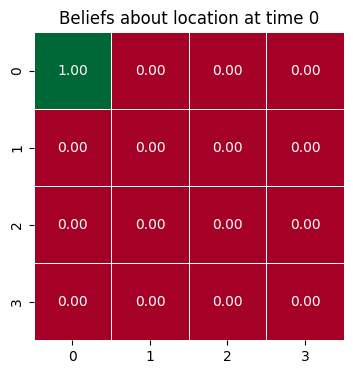

Action at time 0: down
Transition Prob: 
[[0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


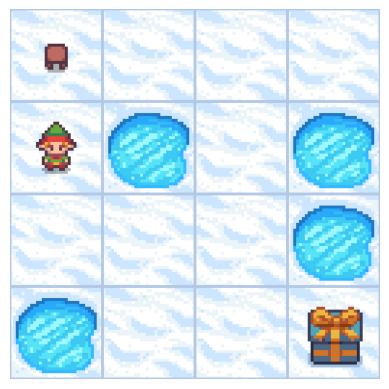

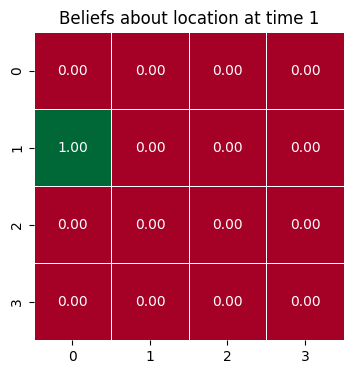

Action at time 1: left
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


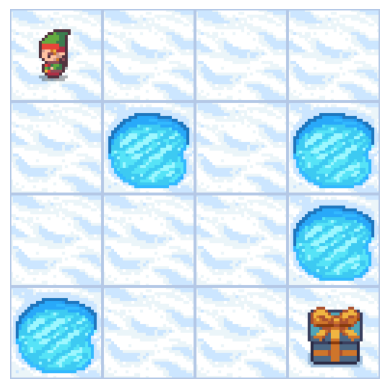

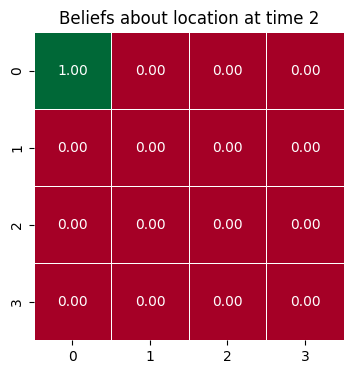

Action at time 2: right
Transition Prob: 
[[0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


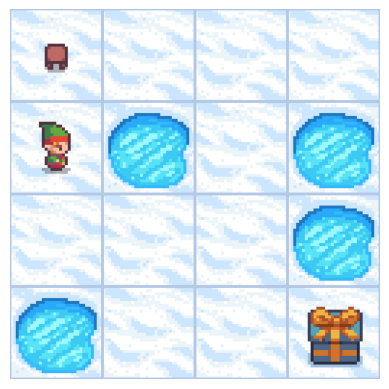

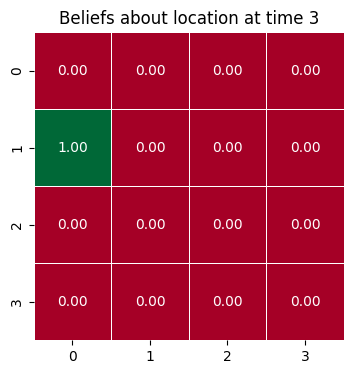

Action at time 3: left
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


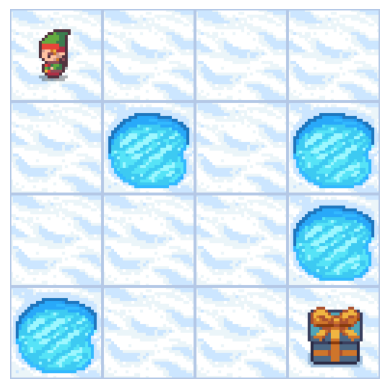

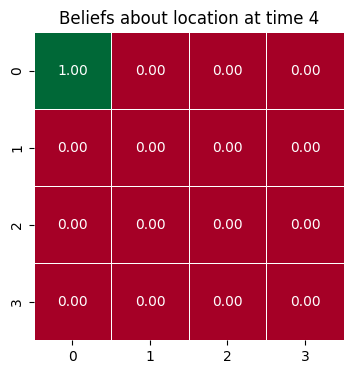

Action at time 4: right
Transition Prob: 
[[0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


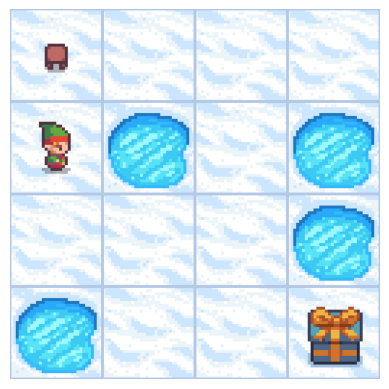

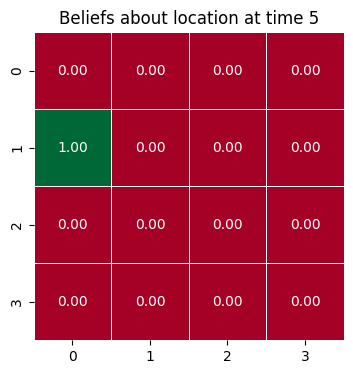

Action at time 5: left
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


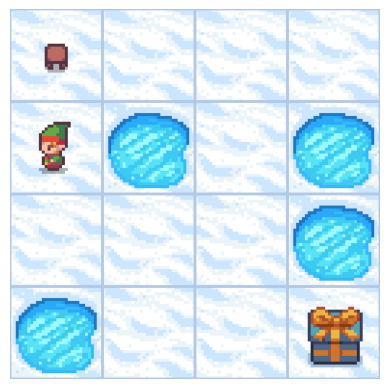

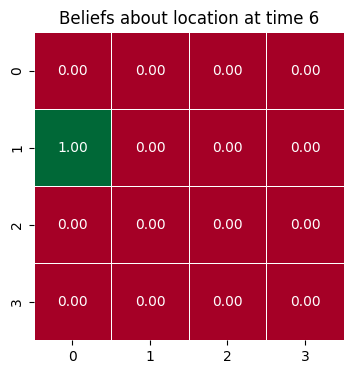

Action at time 6: left
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


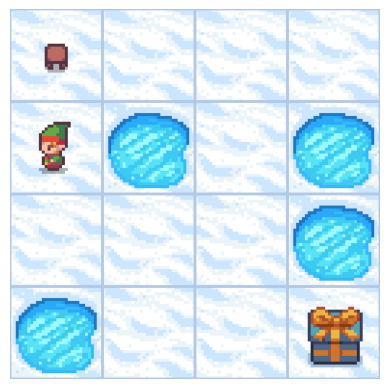

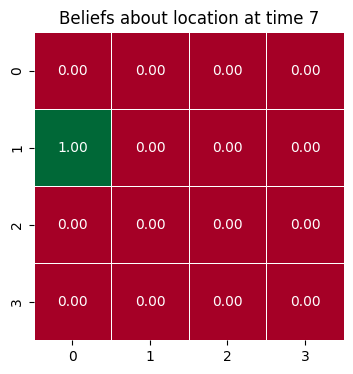

Action at time 7: left
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


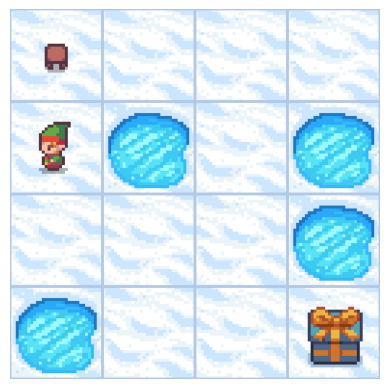

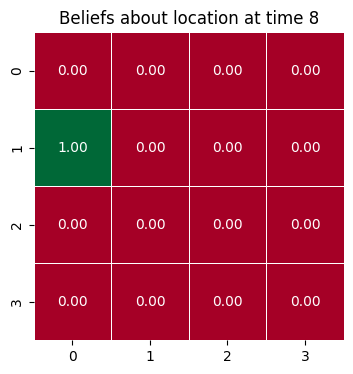

Action at time 8: left
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


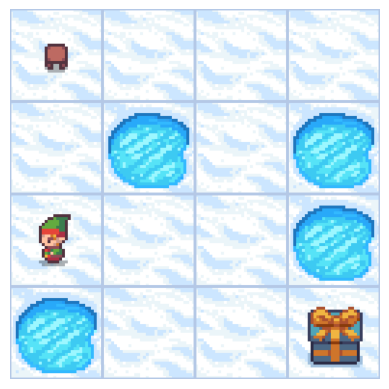

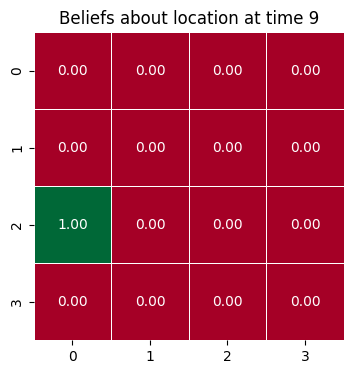

Action at time 9: up
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]]


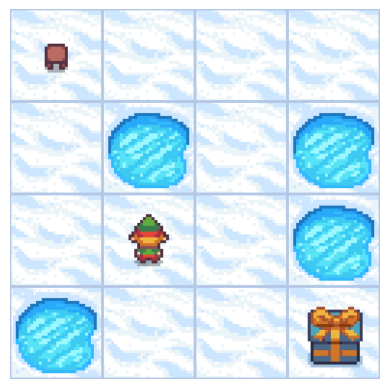

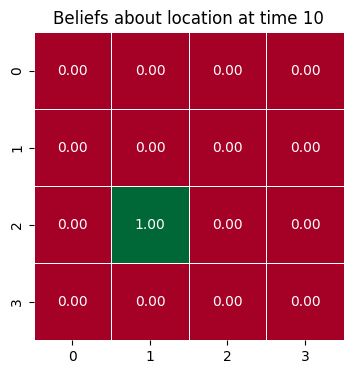

Action at time 10: down
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.33333333 0.         0.33333333 0.        ]
 [0.         0.33333333 0.         0.        ]]


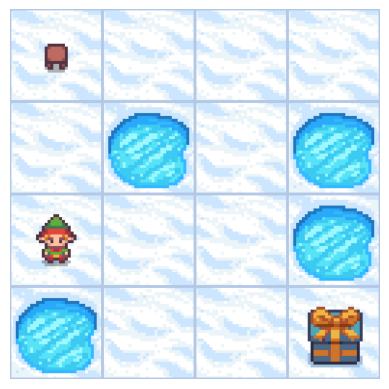

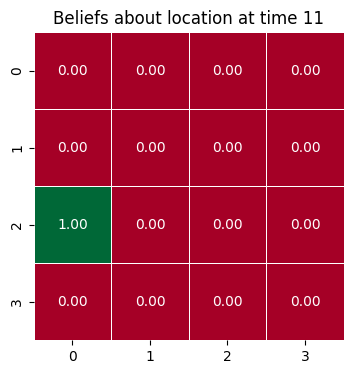

Action at time 11: up
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]]


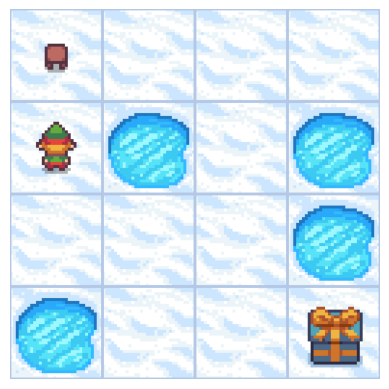

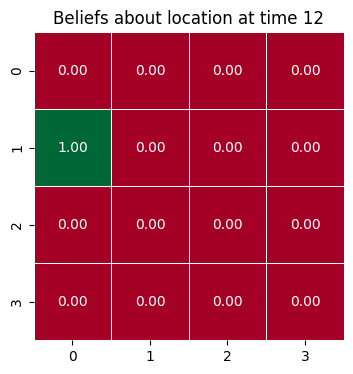

Action at time 12: left
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


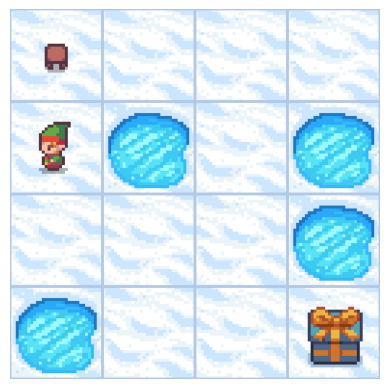

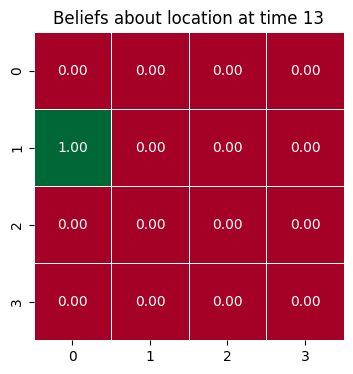

Action at time 13: left
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


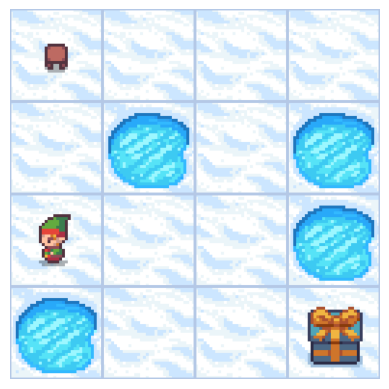

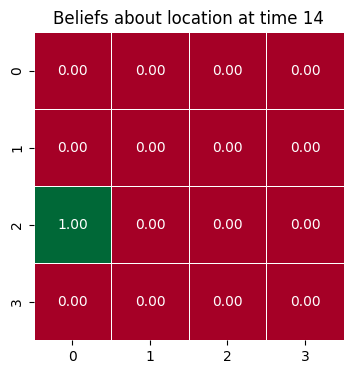

Action at time 14: up
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]]


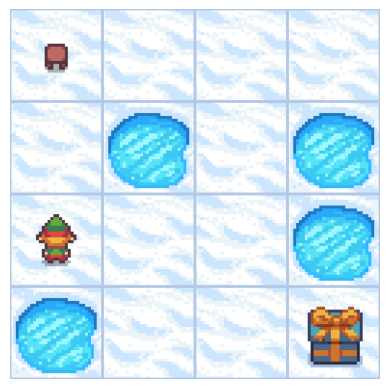

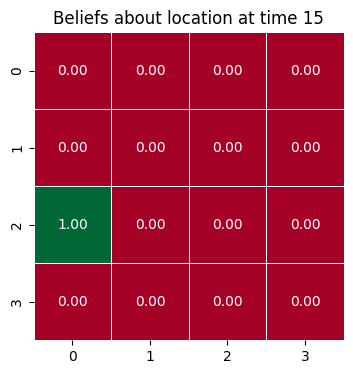

Action at time 15: up
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.         0.        ]]


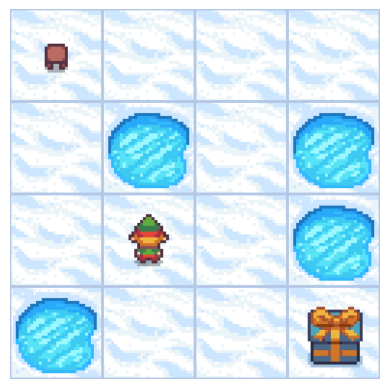

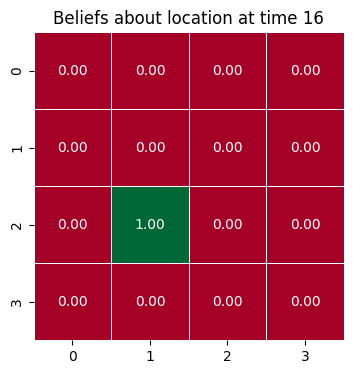

Action at time 16: down
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.33333333 0.         0.33333333 0.        ]
 [0.         0.33333333 0.         0.        ]]


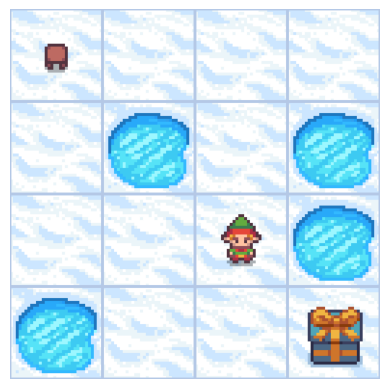

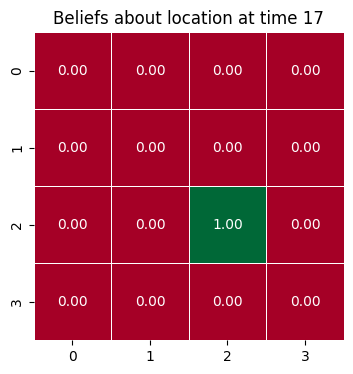

Action at time 17: down
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.33333333 0.         0.33333333]
 [0.         0.         0.33333333 0.        ]]


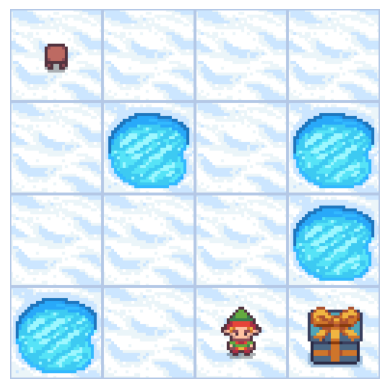

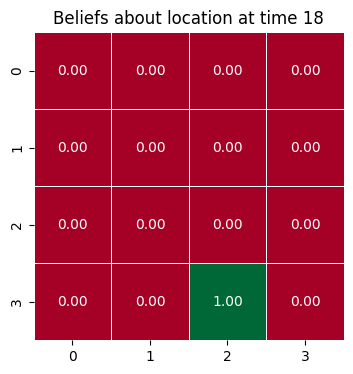

Action at time 18: right
Transition Prob: 
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.33333333 0.33333333 0.33333333]]


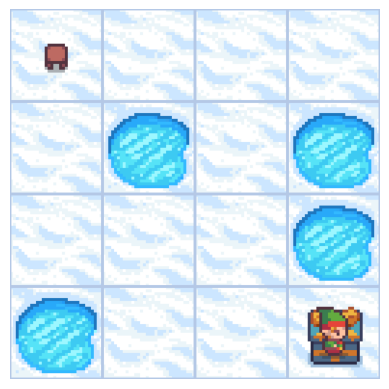

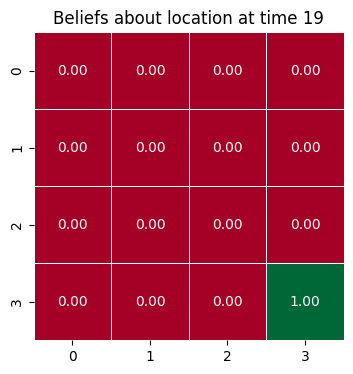

Action at time 19: down
Transition Prob: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]


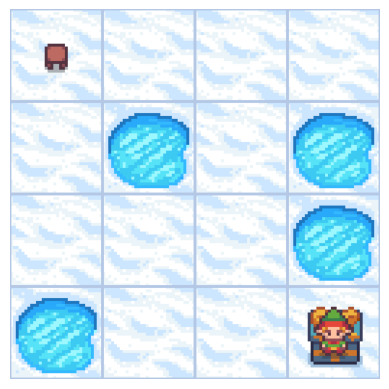

100%|██████████| 50/50 [2:23:56<00:00, 172.73s/it]  


In [17]:
trajectory_goals_1 = []
trajectory_holes_1 = []
all_obs_histories = []

epochs = 50 
T = 20 # single trajectory timesteps

for epoch in tqdm(range(epochs)):
    # verbose for first trajectory 
    if epoch == 0:
        verbose = True
    else:
        verbose = False

    # simulate a trajectory
    obs_history, _ = simulate_trajectory(agent, T, update_B=False, action_sample_method='efe', verbose=verbose)

    all_obs_histories.append(obs_history)
    # calculate how often the agent observes reward vs holes for the entire trajectory
    num_holes, num_goals = evaluate_trajectory(obs_history)
    trajectory_goals_1.append(num_goals)
    trajectory_holes_1.append(num_holes)

In [18]:
print(f'Number of goals observed over t={T}, averaged over {epochs} epochs: {np.mean(trajectory_goals_1)}')
print(f'Number of holes observed over t={T}, averaged over {epochs} epochs: {np.mean(trajectory_holes_1)}')
np.std(trajectory_goals_1), np.std(trajectory_holes_1)

Number of goals observed over t=20, averaged over 50 epochs: 5.52
Number of holes observed over t=20, averaged over 50 epochs: 1.1


(np.float64(4.742320107289258), np.float64(0.8774964387392122))

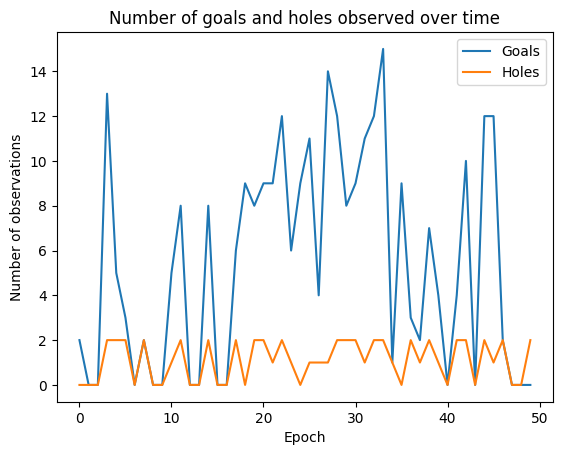

In [19]:
# plot the number of holes and goals observed over time
plt.plot(trajectory_goals_1, label='Goals')
plt.plot(trajectory_holes_1, label='Holes')
plt.xlabel('Epoch')
plt.ylabel('Number of observations')
plt.title('Number of goals and holes observed over time')
plt.legend()
plt.show()

In [20]:
all_obs_histories_np = np.array(all_obs_histories)
all_obs_histories_np.shape

(50, 21, 2)

In [22]:
states_trajs = all_obs_histories_np[:,:,0]
states_trajs

array([[ 0,  4,  0, ..., 14, 15, 15],
       [ 0,  4,  4, ...,  0,  0,  0],
       [ 0,  4,  8, ...,  1,  2,  2],
       ...,
       [ 0,  1,  1, ...,  1,  1,  2],
       [ 0,  0,  1, ...,  4,  0,  1],
       [ 0,  4,  4, ...,  6,  7, 11]], shape=(50, 21))

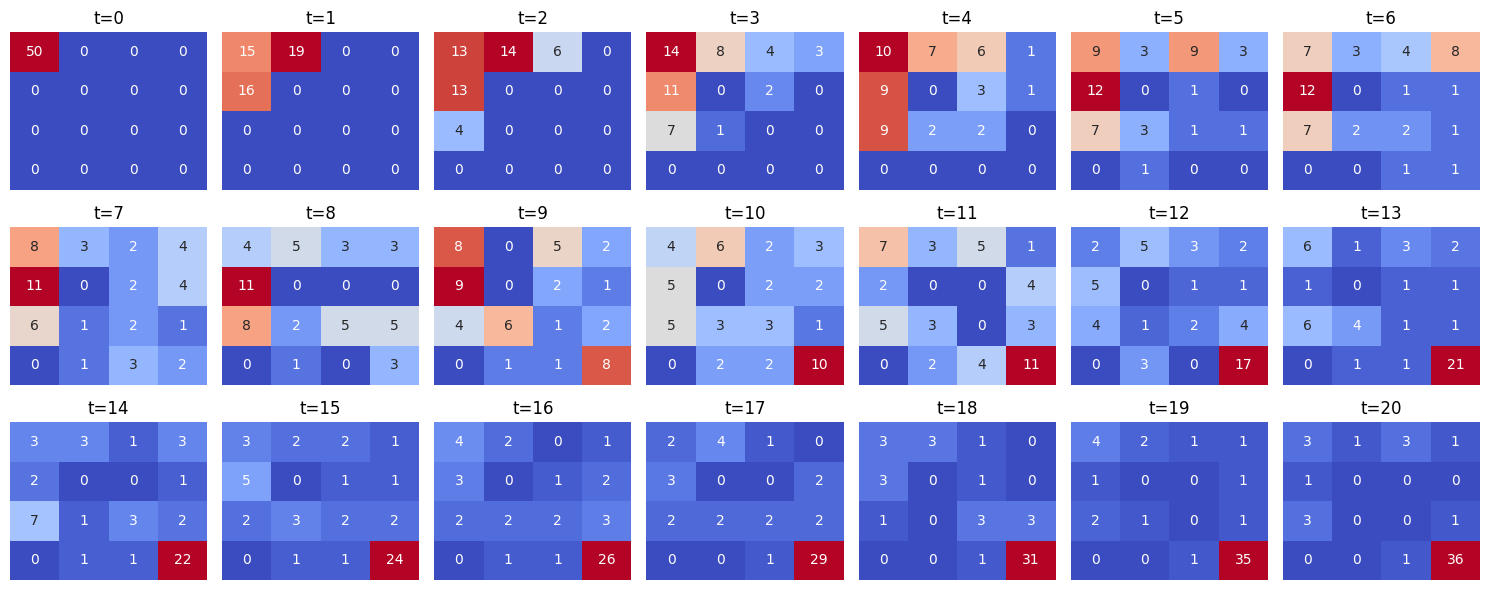

In [30]:
# Function to convert state index to 2D grid coordinates
def index_to_coords(index):
    return divmod(index, 4)  # Convert 0-15 to (row, col) in a 4x4 grid

# Function to generate heatmaps for each timestep in a single plot
def plot_trajectory_heatmaps_subplots(trajectories, grid_size=(4, 4)):
    num_trajectories, num_timesteps = trajectories.shape
    heatmaps = np.zeros((num_timesteps, grid_size[0], grid_size[1]))
    
    # Aggregate state visits across trajectories for each timestep
    for t in range(num_timesteps):
        for trajectory in trajectories:
            row, col = index_to_coords(trajectory[t])
            heatmaps[t, row, col] += 1
    
    # Create subplots
    cols = 7  # Number of columns in the subplot grid
    rows = (num_timesteps + cols - 1) // cols  # Compute rows based on timesteps
    fig, axes = plt.subplots(rows, cols, figsize=(15, 2 * rows))
    axes = axes.flatten()  # Flatten the axes for easier indexing

    # Plot heatmaps
    for t in range(num_timesteps):
        sns.heatmap(heatmaps[t], ax=axes[t], annot=True, cmap="coolwarm", cbar=False,
                    xticklabels=False, yticklabels=False)
        axes[t].set_title(f"t={t}")
        axes[t].set_xlabel("")
        axes[t].set_ylabel("")

    # Turn off empty subplots
    for t in range(num_timesteps, len(axes)):
        axes[t].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot the heatmaps
plot_trajectory_heatmaps_subplots(states_trajs)

In [66]:
from matplotlib.lines import Line2D

# Define the frozen lake holes (using 0-based indexing for a 4x4 grid)
holes = [5, 7, 11, 12]  # Example hole positions

# Function to convert state index to 2D grid coordinates
def index_to_coords(index):
    return divmod(index, 4)  # Convert 0-15 to (row, col) in a 4x4 grid

# increase the dpi of plots
plt.rcParams['figure.dpi'] = 1000

# Function to generate heatmaps for each timestep with holes indicated
def plot_trajectory_heatmaps_with_shapes(trajectories, holes, grid_size=(4, 4)):
    num_trajectories, num_timesteps = trajectories.shape
    heatmaps = np.zeros((num_timesteps, grid_size[0], grid_size[1]))
    
    # Aggregate state visits across trajectories for each timestep
    for t in range(num_timesteps):
        for trajectory in trajectories:
            row, col = index_to_coords(trajectory[t])
            heatmaps[t, row, col] += 1
    
    # Convert hole indices to grid coordinates
    hole_coords = [index_to_coords(hole) for hole in holes]

    # Create subplots
    cols = 7  # Number of columns in the subplot grid
    rows = (num_timesteps + cols - 1) // cols  # Compute rows based on timesteps
    fig, axes = plt.subplots(rows, cols, figsize=(15, 2 * rows))
    axes = axes.flatten()  # Flatten the axes for easier indexing

    # Plot heatmaps
    for t in range(num_timesteps):
        sns.heatmap(heatmaps[t], ax=axes[t], annot=True, cmap="coolwarm", cbar=False,
                    xticklabels=False, yticklabels=False, annot_kws={'color':'w'})
        
        # Overlay shapes for holes
        for row, col in hole_coords:
            axes[t].plot(col + 0.5, row + 0.5, marker='o', color='black', markersize=15, markeredgewidth=2, alpha=0.5)

        axes[t].plot(0.5, 0.5, marker='s', color='black', markersize=15, markeredgewidth=2, alpha=0.3)  # Start state
        axes[t].plot(3.5, 3.5, marker='D', color='black', markersize=15, markeredgewidth=2, alpha=0.3)  # Goal state
        axes[t].set_title(f"t={t}")
        axes[t].set_xlabel("")
        axes[t].set_ylabel("")

    # Turn off empty subplots
    for t in range(num_timesteps, len(axes)):
        axes[t].axis('off')
    
    # Add a legend for the holes
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='Start', markerfacecolor='black', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Hole', markerfacecolor='black', markersize=10),
        Line2D([0], [0], marker='D', color='w', label='Goal', markerfacecolor='black', markersize=10),
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=3)
    fig.suptitle('Agents Trajectories with True Dynamics', fontsize=16)
    plt.tight_layout()
    fig.savefig('age_trajs2.eps', format='eps', dpi=1000)
    plt.show()

# Plot the heatmaps
plot_trajectory_heatmaps_with_shapes(states_trajs, holes)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
